In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

/home/apk/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
eeg=h5py.File("ME_10_P_2019.02.21_16.20.56.hdf5",mode='r')
keys2= list(eeg.keys())
print keys2
keys1= list(eeg[keys2[0]].keys())
print keys1
#print eeg[keys2[0]][keys1[0]]
#eeg["RawData"]['Samples']
print list(eeg['RawData'].keys())
print eeg['RawData']['Samples']
sampletime = np.array(eeg['AsynchronData']["Time"])
time=sampletime/256.0
sampletime1=np.delete(sampletime, len(sampletime)-1)
sampletime1=np.delete(sampletime1, 0)
print sampletime1

[u'AsynchronData', u'RawData', u'SavedFeatues', u'Version']
[u'AsynchronSignalTypes', u'Time', u'TypeID', u'Value']
[u'AcquisitionTaskDescription', u'DAQDeviceCapabilities', u'DAQDeviceDescription', u'Samples', u'SessionDescription', u'SubjectDescription']
<HDF5 dataset "Samples": shape (25445, 64), type "<f4">
[13656 16151 18276 20771 22921]


In [3]:
samples=np.array(eeg['RawData']['Samples'])
samples=samples.T
sf=[]
ts=[]
for s in sampletime1:
    sample=[]
   
    for j in range (0, len(samples)):
        sample.append(samples[j][s-384:s+512])
        
    sf.append(sample)
    ts.append(np.arange(s-384, s+512))

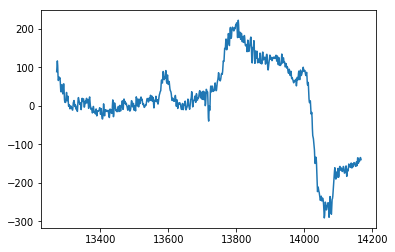

In [4]:
plt.plot(ts[0], (sf[0][0]))

64


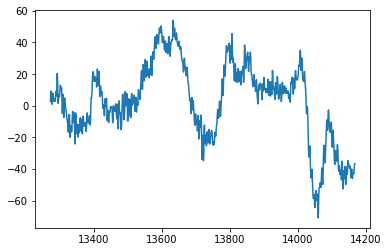

In [5]:
avgarr=[]
for j in range (0, 64):
    avg=0.0
    for i in range (0, len(sf)):
        avg=avg+sf[i][0]/5.0
    avgarr.append(avg)
plt.plot(ts[0],avgarr[0])
print len(avgarr)

In [6]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

64


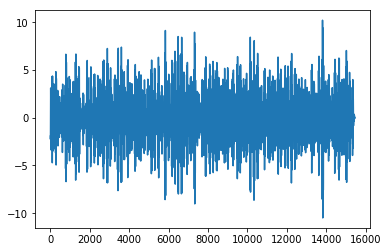

In [14]:
import scipy.signal as signal
alpha=[]
beta=[]
gamma=[]
delta=[]
theta=[]
freq=[[0.5, 4], [4, 8], [8, 12], [12, 30], [30, 100]]
fs=256
order=3


for i in range (0, len(avgarr)):
    b, a = butter_bandpass(0.1, 100, fs, order=order)
    samples[i]=(signal.filtfilt(b, a, samples[i], padlen=0))
    samples[0][13250:13500]=signal.filtfilt(b, a, samples[0][13250:13500], padlen=0)
    b, a = butter_bandpass(freq[0][0], freq[0][1], fs, order=order)
    delta.append(signal.filtfilt(b, a, avgarr[i], padlen=10))
    b, a = butter_bandpass(freq[1][0], freq[1][1], fs, order=order)
    theta.append(signal.filtfilt(b, a, avgarr[i], padlen=10))
    b, a = butter_bandpass(freq[2][0], freq[2][1], fs, order=order)
    alpha.append(signal.filtfilt(b, a, samples[i], padlen=10))
    b, a = butter_bandpass(freq[3][0], freq[3][1], fs, order=order)
    beta.append(signal.filtfilt(b, a, avgarr[i], padlen=10))
    b, a = butter_bandpass(freq[4][0], freq[4][1], fs, order=order)
    gamma.append(signal.filtfilt(b, a, samples[i], padlen=10))
    
plt.plot(np.arange(len(alpha[60])-10000), alpha[60][10000:])
print len(avgarr)

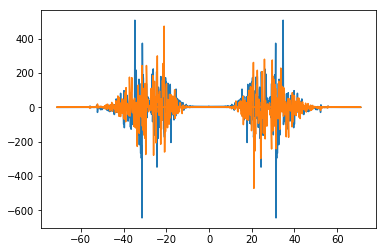

In [8]:
t=np.arange(896)
freq = np.fft.fftfreq(t.shape[-1])*896/np.pi/2.0
sp=np.fft.fft(gamma[60])
plt.plot(freq, sp.real, freq, sp.imag)

In [9]:
3.5*256

896.0

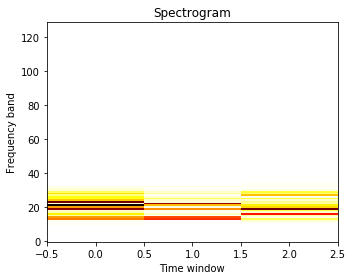

In [10]:
freqs, times, spectrogram = signal.spectrogram(beta[0])

plt.figure(figsize=(5, 4))
plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
plt.title('Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
plt.tight_layout()

Text(0,0.5,'Power')

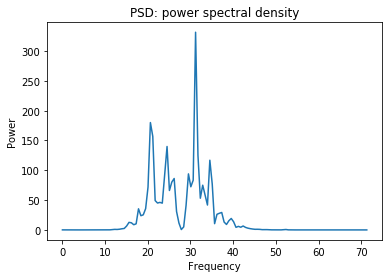

In [10]:
freqs, psd = signal.welch(gamma[50])
freqs=freqs*896/2/np.pi
#plt.figure(figsize=(5, 4))
#plt.semilogx(freqs, psd)
plt.plot(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
#plt.tight_layout()

In [12]:
import pywt

In [13]:
print pywt.families()

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']


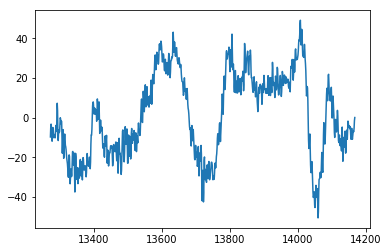

In [14]:
plt.plot(ts[0],avgarr[0])

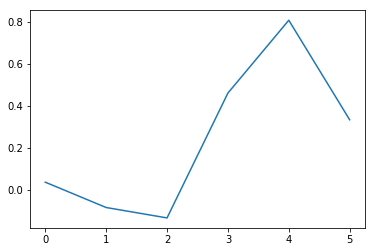

In [15]:
w = pywt.Wavelet('db3')
plt.plot(w.dec_lo)
coeffs = pywt.wavedec(samples[0][13250:13500], w, level=4)

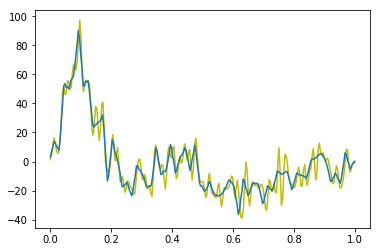

In [16]:
def reconstruction_plot(yyy, **kwargs):
    """Plot signal vector on x [0,1] independently of amount of values it contains."""
    plt.plot(np.linspace(0, 1, len(yyy)), yyy, **kwargs)

reconstruction_plot(pywt.waverec(coeffs, w), color='y') # full reconstruction 
#reconstruction_plot(pywt.waverec(coeffs[:-1] + [None] * 1, w)) # leaving out detail coefficients up to lvl 5
reconstruction_plot(pywt.waverec(coeffs[:-2] + [None] * 2, w)) # leaving out detail coefficients up to lvl 4
#reconstruction_plot(pywt.waverec(coeffs[:-3] + [None] * 3, w)) # leaving out detail coefficients up to lvl 3
#reconstruction_plot(pywt.waverec(coeffs[:-4] + [None] * 4, w)) # leaving out detail coefficients up to lvl 2
#reconstruction_plot(pywt.waverec(coeffs[:-5] + [None] * 5, w)) # leaving out detail coefficients up to lvl 1
#reconstruction_plot(pywt.waverec(coeffs[:-6] + [None] * 6, w)) # leaving out all detail coefficients = reconstruction using lvl1 approximation only
#plt.legend(['Full reconstruction', 'Reconstruction using detail coefficients lvl 1+2', 'Reconstruction using lvl 1 approximation only'])

32.66706740856171


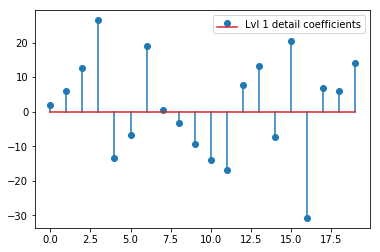

In [18]:
plt.stem(coeffs[1]); plt.legend(['Lvl 1 detail coefficients'])
print sum(coeffs[1])

-5.530744016170502


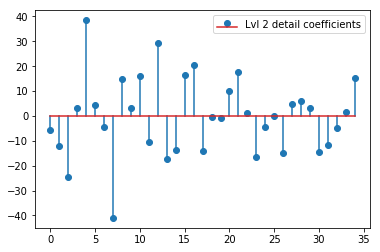

In [19]:
print sum(coeffs[2])
plt.stem(coeffs[2]); plt.legend(['Lvl 2 detail coefficients'])

-40.33061546087265


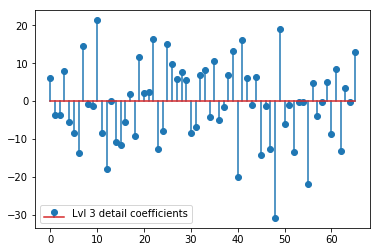

In [20]:
plt.stem(coeffs[3]); plt.legend(['Lvl 3 detail coefficients'])
print sum(coeffs[3])

1.667166255414486


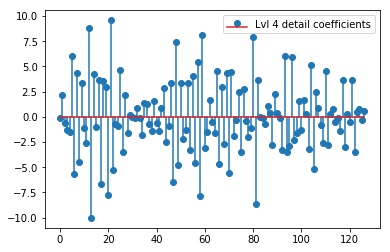

In [21]:
plt.stem(coeffs[4]); plt.legend(['Lvl 4 detail coefficients'])
print sum(coeffs[4])

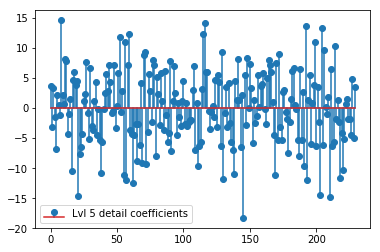

In [20]:
plt.stem(coeffs[5]); plt.legend(['Lvl 5 detail coefficients'])

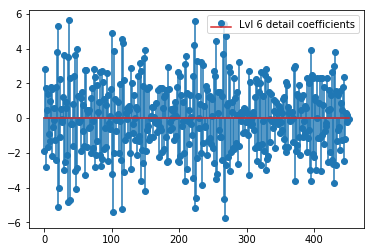

In [21]:
plt.stem(coeffs[6]); plt.legend(['Lvl 6 detail coefficients'])

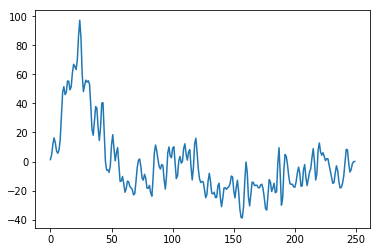

In [22]:
plt.plot(np.arange(250), samples[0][13250:13500])

In [48]:
import scipy.stats as st
import math

In [64]:
c=abs(coeffs[1])
print -np.log(c)
print st.entropy(c)

[-0.66331553 -1.8010163  -2.5424664  -3.276519   -2.6079113  -1.9094131
 -2.9508111   0.49621564 -1.1987612  -2.251342   -2.6489584  -2.832508
 -2.0351634  -2.5907469  -2.0032234  -3.0177147  -3.427083   -1.9294076
 -1.7720792  -2.6392236 ]
2.7790864
